# Multi-Component 2-D Gaussian Fitting — Tutorial

This notebook demonstrates the major features of:

- `astroviper.fitting.multi_gaussian2d_fit.fit_multi_gaussian2d`
- `astroviper.fitting.multi_gaussian2d_fit.plot_components` (if available)

You’ll learn how to:
- Fit one or many 2-D Gaussians (sum of components) to images or data cubes
- Use NumPy, Dask, or Xarray inputs and vectorize over extra dims
- Provide initial guesses (array / list-of-dicts / dict-with-components)
- Apply bounds (including fixing parameters with equal bounds)
- Use thresholds to mask pixels during the fit
- Work with angle conventions: `"math"`, `"pa"`, and `"auto"`
- Get world coordinates of centroids when axis coords are provided
- Return fitted model plane(s) and residuals

**Tip:** Run cells top-to-bottom. All cells are self-contained and documented.

## Imports & Utilities

In [1]:
import numpy as np
import xarray as xr
import dask.array as da
import matplotlib.pyplot as plt

from astroviper.fitting.multi_gaussian2d_fit import fit_multi_gaussian2d
from astroviper.model.component_models import make_gauss2d

from astroviper.fitting.multi_gaussian2d_fit import plot_components
from astroviper.utils.plotting import plot_correct_orientation

# Reproducibility
rng = np.random.default_rng(1234)

### Utility: synthetic Gaussian scenes
Helpers used only to generate synthetic test images for this tutorial.

In [2]:
def make_scene_via_component_models(
    ny: int,
    nx: int,
    components: list[dict],
    *,
    offset: float = 0.1,
    noise_std: float = 0.02,
    seed: int | None = None,
    coords: bool = True,
    angle: str = "math",  # "math" | "pa" | "auto" — same semantics as astroviper's model
    x_world: tuple[float, float] = (0.0, 1.0),
    y_world: tuple[float, float] = (0.0, 1.0),
) -> xr.DataArray:
    """
    Build a synthetic image using astroviper.model.component_models.(make_gaussian|make_gauss2d).

    components: list of dicts with keys:
      {"amp"/"amplitude","x0","y0","sigma_x","sigma_y","theta"}.
    """
    rng = np.random.default_rng(seed)
    # coords
    if coords:
        x0, x1 = x_world
        y0, y1 = y_world
        x = np.linspace(x0, x1, nx, dtype=float)
        y = np.linspace(y0, y1, ny, dtype=float)
    else:
        x = np.arange(nx, dtype=float)
        y = np.arange(ny, dtype=float)
    # accumulate model in float64
    z = np.zeros((ny, nx), dtype=float)
    for c in components:
        amp = float(c.get("amp", c.get("amplitude")))
        x0c = float(c["x0"])
        y0c = float(c["y0"])
        fwhm_x = float(c["fwhm_major"])
        fwhm_y = float(c["fwhm_minor"])
        thc = float(c.get("theta", 0.0))

        # astroviper's generator uses coords + angle convention, returns (ny,nx)
        z = make_gauss2d(
            data=z,
            a=fwhm_x,
            b=fwhm_y,
            theta=thc,
            x0=x0c,
            y0=y0c,
            peak=amp,
            x_coord="x",
            y_coord="y",
            coords={"x": x, "y": y},
            add=True,
            angle=angle,
        )

    z += float(offset)
    if noise_std > 0:
        z += rng.normal(scale=noise_std, size=z.shape)

    da = xr.DataArray(z, dims=("y", "x"))
    if coords:
        da = da.assign_coords(x=x, y=y)
    return da

## Getting your feet wet. Just supplying the data and the number of desired components to be fit.

### Fit a single Gaussian in noiseless image to prove functionality

Here we create a single gaussian model. The image we pass to the fitter is noiseless; this is
a basic example that demonstrates the minimum functionality.

type of returned data <class 'xarray.core.dataarray.DataArray'>


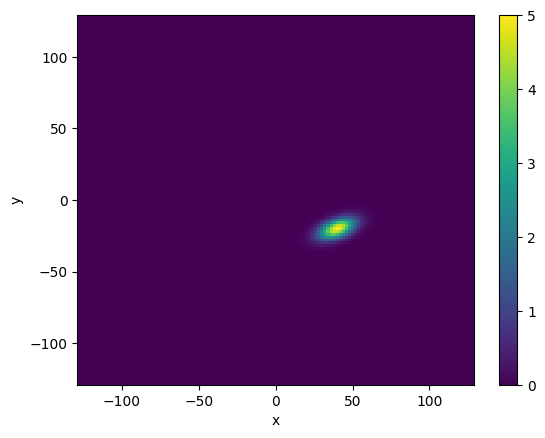

In [3]:
# size of image
nx = 129
ny = 129

# model componenet
comp = [
    dict(amp=5.0, x0=40, y0=-20, fwhm_major=20.0, fwhm_minor=10.0, theta=0.4)
]

data = make_scene_via_component_models(
    ny=ny,
    nx=nx,
    components=comp,
    offset=0.0,
    noise_std=0,
    x_world=(-nx+1, nx-1),
    y_world=(-ny+1, ny-1),
)

print("type of returned data", type(data))

# plot the model
plot_correct_orientation(data, "x", "y")

### Perform the fit

Feed the image the data. You can supply an initial guess to provide a starting point, but its
not required. It is generally advisable to supply an initial guess for low S/N or multiple 
componenets. Here we are doing the minimum. In cases of blended components an initial guess
will almost certainly have to be supplied. We will simply pass in the data and specify we
want one Gaussian to be fit. The application will make an initial guess itself if we
don't supply one.

The output is an xr.DataArray with the data variables holding the fit parameters. The
parameters are self-documenting; each contains a "description" attr explaining what it
represents.

The fit parameters should be equal to those in the model, with perhaps differences of
the order of machine precision.

In [4]:
print("the model we are fitting is", comp)

# preform the fit.
fit = fit_multi_gaussian2d(data, n_components=1)
fit

the model we are fitting is [{'amp': 5.0, 'x0': 40, 'y0': -20, 'fwhm_major': 20.0, 'fwhm_minor': 10.0, 'theta': 0.4}]


<xarray.Dataset> Size: 135kB
Dimensions:                (component: 1, x: 129, y: 129)
Coordinates:
  * x                      (x) float64 1kB -128.0 -126.0 -124.0 ... 126.0 128.0
  * y                      (y) float64 1kB -128.0 -126.0 -124.0 ... 126.0 128.0
Dimensions without coordinates: component
Data variables: (12/33)
    amplitude              (component) float64 8B 5.0
    amplitude_err          (component) float64 8B 4.332e-16
    peak                   (component) float64 8B 5.0
    x0_pixel               (component) float64 8B 84.0
    y0_pixel               (component) float64 8B 54.0
    x0_pixel_err           (component) float64 8B 3.464e-16
    ...                     ...
    variance_explained     float64 8B 1.0
    residual               (y, x) float64 133kB -4.543e-17 ... -4.543e-17
    x0_world               (component) float64 8B 40.0
    y0_world               (component) float64 8B -20.0
    x0_world_err           (component) float64 8B 6.927e-16
    y0_world_err           (component) float64 8B 4.438e-16
Attributes:
    axes_handedness:   right
    call:              fit_multi_gaussian2d(n_components=1)
    param:             {'n_components': 1, 'dims': None, 'min_threshold': Non...
    package:           astroviper
    version:           0.0.18
    fit_native_frame:  world

By default, the returned DataArray contains the fit residuals. In our case
the residual image should be zero, for all intents and purposes. Note that the
order of magnitude of the values along the right side of the color bar is at
the top of the color bar. It should be something like 1e-14.

<xarray.DataArray 'residual' ()> Size: 8B
array(3.41948692e-14)


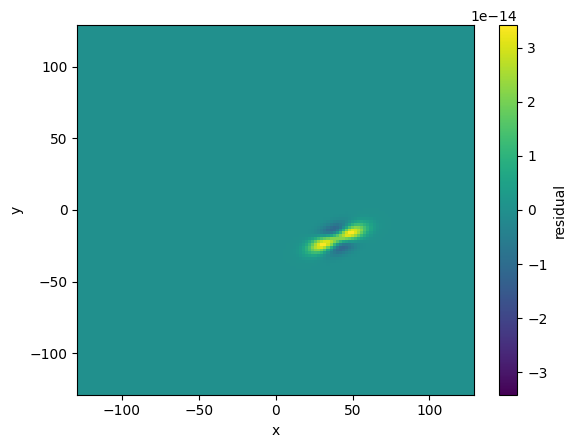

In [5]:
print(fit["residual"].max())
plot_correct_orientation(fit["residual"], "x", "y")

### Two Gaussians in noiseless image

Let's add another componenet and fit two Gaussians simultaneously.

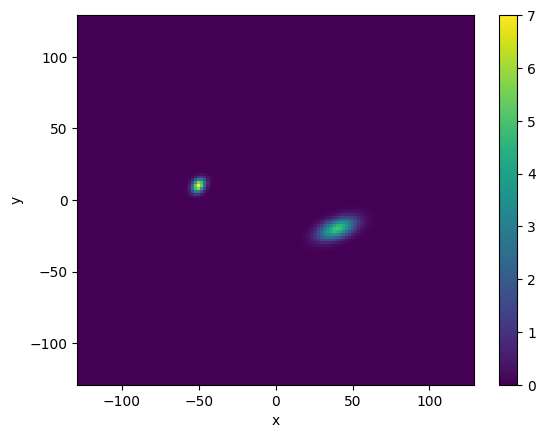

In [6]:
comp.append(dict(amp=7.0, x0=-50, y0=10, fwhm_major=8.0, fwhm_minor=6.0, theta=1))

data = make_scene_via_component_models(
    ny=ny,
    nx=nx,
    components=comp,
    offset=0.0,
    noise_std=0,
    x_world=(-nx+1, nx-1),
    y_world=(-ny+1, ny-1),
)

# plot the model
plot_correct_orientation(data, "x", "y")

As before, the fit errors should be on the order of machine precision. 

In [7]:
print("the model we are fitting is", comp)

# preform the fit.
fit = fit_multi_gaussian2d(data, n_components=2)
fit

the model we are fitting is [{'amp': 5.0, 'x0': 40, 'y0': -20, 'fwhm_major': 20.0, 'fwhm_minor': 10.0, 'theta': 0.4}, {'amp': 7.0, 'x0': -50, 'y0': 10, 'fwhm_major': 8.0, 'fwhm_minor': 6.0, 'theta': 1}]


<xarray.Dataset> Size: 136kB
Dimensions:                (component: 2, x: 129, y: 129)
Coordinates:
  * x                      (x) float64 1kB -128.0 -126.0 -124.0 ... 126.0 128.0
  * y                      (y) float64 1kB -128.0 -126.0 -124.0 ... 126.0 128.0
Dimensions without coordinates: component
Data variables: (12/33)
    amplitude              (component) float64 16B 7.0 5.0
    amplitude_err          (component) float64 16B 5.325e-16 2.609e-16
    peak                   (component) float64 16B 7.0 5.0
    x0_pixel               (component) float64 16B 39.0 84.0
    y0_pixel               (component) float64 16B 69.0 54.0
    x0_pixel_err           (component) float64 16B 1.073e-16 2.086e-16
    ...                     ...
    variance_explained     float64 8B 1.0
    residual               (y, x) float64 133kB -5.244e-18 ... -5.244e-18
    x0_world               (component) float64 16B -50.0 40.0
    y0_world               (component) float64 16B 10.0 -20.0
    x0_world_err           (component) float64 16B 2.147e-16 4.171e-16
    y0_world_err           (component) float64 16B 2.414e-16 2.672e-16
Attributes:
    axes_handedness:   right
    call:              fit_multi_gaussian2d(n_components=2)
    param:             {'n_components': 2, 'dims': None, 'min_threshold': Non...
    package:           astroviper
    version:           0.0.18
    fit_native_frame:  world

The maximum residual value should be on the order of 1e-14.

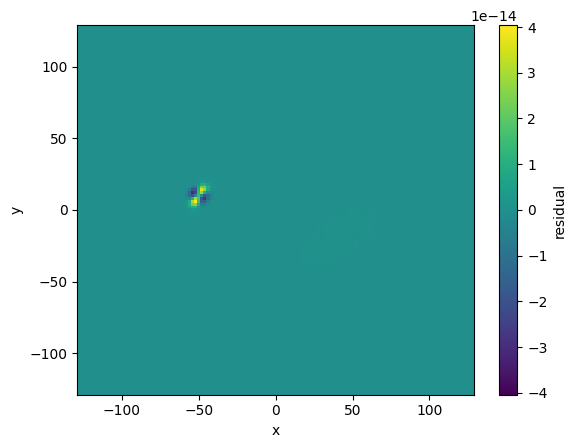

In [8]:
plot_correct_orientation(fit["residual"], "x", "y")

### Fitting with noise

Now let's add some noise and fit wo the uncertainties will be more interesting

noise level <xarray.DataArray ()> Size: 8B
array(0.49488321)
noise min, max <xarray.DataArray ()> Size: 8B
array(-1.85811916) <xarray.DataArray ()> Size: 8B
array(1.86357202)


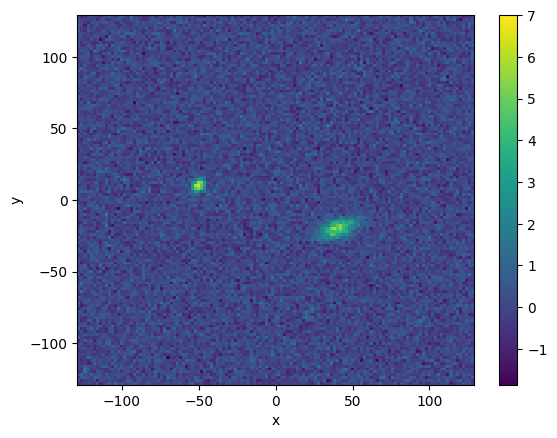

In [9]:
data = make_scene_via_component_models(
    ny=ny,
    nx=nx,
    components=comp,
    offset=0.0,
    noise_std=0.5,
    x_world=(-nx+1, nx-1),
    y_world=(-ny+1, ny-1),
)

noise_reg = data[:, 0:32]
std = noise_reg.std()
noise_min = noise_reg.min()
noise_max = noise_reg.max()

print("noise level", std)
print("noise min, max", noise_min, noise_max)

# plot the model
plot_correct_orientation(data, "x", "y", vmin=noise_min,vmax=7.0)

In [10]:
print("the model we are fitting is", comp)

# preform the fit.
fit = fit_multi_gaussian2d(data, n_components=2)

fit

the model we are fitting is [{'amp': 5.0, 'x0': 40, 'y0': -20, 'fwhm_major': 20.0, 'fwhm_minor': 10.0, 'theta': 0.4}, {'amp': 7.0, 'x0': -50, 'y0': 10, 'fwhm_major': 8.0, 'fwhm_minor': 6.0, 'theta': 1}]


<xarray.Dataset> Size: 136kB
Dimensions:                (component: 2, x: 129, y: 129)
Coordinates:
  * x                      (x) float64 1kB -128.0 -126.0 -124.0 ... 126.0 128.0
  * y                      (y) float64 1kB -128.0 -126.0 -124.0 ... 126.0 128.0
Dimensions without coordinates: component
Data variables: (12/33)
    amplitude              (component) float64 16B 6.758 5.185
    amplitude_err          (component) float64 16B 0.2668 0.1316
    peak                   (component) float64 16B 6.761 5.188
    x0_pixel               (component) float64 16B 38.98 84.2
    y0_pixel               (component) float64 16B 69.02 54.07
    x0_pixel_err           (component) float64 16B 0.05775 0.1041
    ...                     ...
    variance_explained     float64 8B 0.2074
    residual               (y, x) float64 133kB -0.725 -0.4697 ... -0.1106
    x0_world               (component) float64 16B -50.04 40.4
    y0_world               (component) float64 16B 10.05 -19.87
    x0_world_err           (component) float64 16B 0.1155 0.2081
    y0_world_err           (component) float64 16B 0.1225 0.1262
Attributes:
    axes_handedness:   right
    call:              fit_multi_gaussian2d(n_components=2)
    param:             {'n_components': 2, 'dims': None, 'min_threshold': Non...
    package:           astroviper
    version:           0.0.18
    fit_native_frame:  world

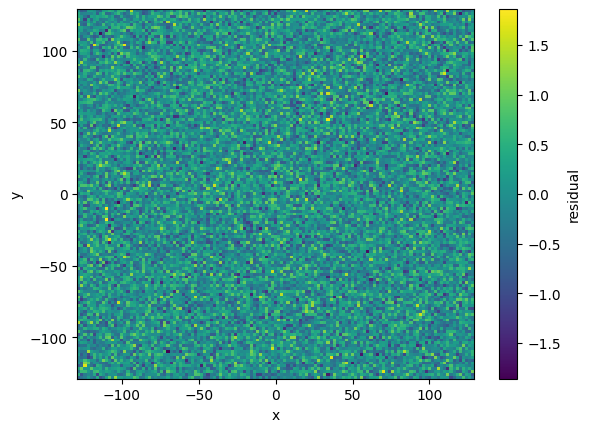

In [11]:
plot_correct_orientation(fit["residual"], "x", "y")

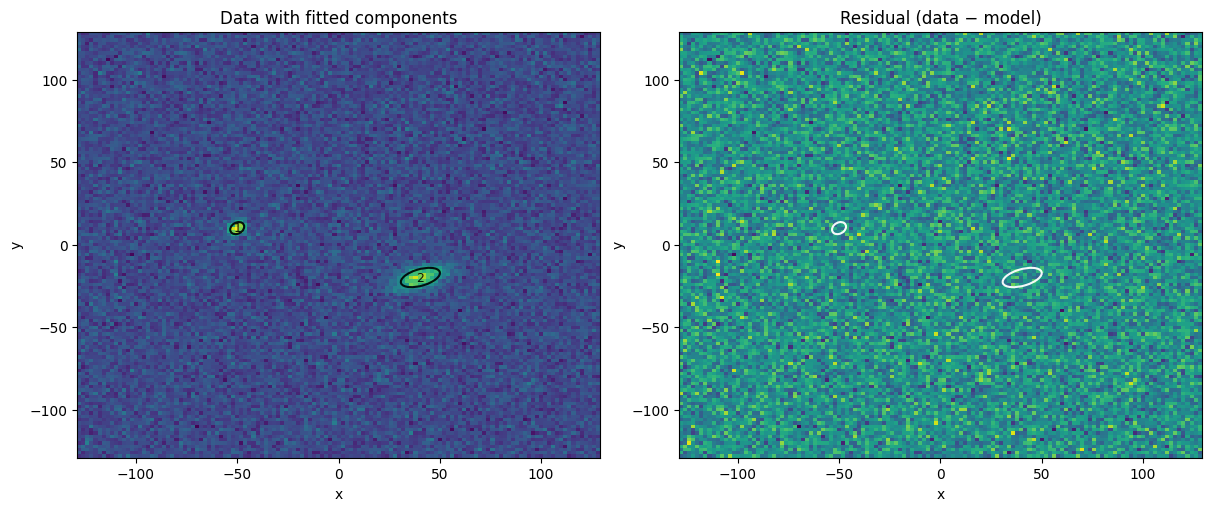

In [12]:
if plot_components is not None:
    plot_components(data, fit, dims=("x", "y"), show_residual=True, fwhm=True)
else:
    print("plot_components helper is not available in this build.")

## 2) Basic: Fit two Gaussians on a 2-D image
- Xarray `DataArray` with dims `("y","x")`.
- Initial guesses as `(N,6)` array: `[amp, x0, y0, sigma_x, sigma_y, theta]`.
- Get parameters, uncertainties, derived metrics + diagnostics.

In [11]:
ny, nx = 128, 128
true = [
    {"amp": 1.0, "x0": 42.0, "y0": 60.0, "fwhm_x": 3.0, "fwhm_y": 3.0, "theta": 0.0},
    {"amp": 0.7, "x0": 92.0, "y0": 35.0, "fwhm_x": 5.0, "fwhm_y": 2.5, "theta": 0.4},
]
img = make_scene_via_component_models(ny, nx, true, offset=0.12, noise_std=0.03, coords=True)

ax = img.plot.imshow(origin="lower", robust=True)  # robust=True avoids outlier stretch
ax.axes.set_title("Raw image")
ax.axes.set_aspect("equal")

init_arr = np.array(
    [
        [0.9, 40.0, 61.0, 3.0, 3.0, 0.0],
        [0.6, 90.0, 34.0, 4.8, 2.7, 0.4],
    ],
    dtype=float,
)

ds_basic = fit_multi_gaussian2d(
    img, n_components=2, initial_guesses=init_arr, return_residual=True, return_model=True
)
print("Input model: ", comp[0])
ds_basic

KeyError: 'fwhm_major'

### Quicklook: visualize data, model, residual (if `plot_components` is available)

In [ ]:
if plot_components is not None:
    plot_components(img, ds_basic, dims=("x", "y"), show_residual=True)
else:
    print("plot_components helper is not available in this build.")

## 3) Threshold masking
Ignore pixels outside inclusive `[min_threshold, max_threshold]` during the fit.

In [ ]:
img_thr = img.copy()
img_thr.values[img_thr.values < 0.11] = 0.05
ds_thr = fit_multi_gaussian2d(
    img_thr, n_components=2, initial_guesses=init_arr, min_threshold=0.1, max_threshold=None
)
float(ds_thr.variance_explained)

## 4) Initial guesses formats
Forms:
- **Array (N,6)** — used above.
- **List of N dicts** — supports key synonyms.
- **Dict with `"components"`** — optional `"offset"` seed.
Angles in `initial_guesses` are interpreted per `angle=`.

In [ ]:
# (b) list of dicts
init_list = [
    {"amp": 0.95, "x0": 41.5, "y0": 60.5, "sigma_x": 3.0, "sigma_y": 3.0, "theta": 0.0},
    {"amplitude": 0.68, "x0": 92.5, "y0": 34.5, "sx": 5.0, "sy": 2.5, "theta": 0.4},
]
ds_list = fit_multi_gaussian2d(img, n_components=2, initial_guesses=init_list)

# (c) dict with 'components' and 'offset'
init_dict = {"offset": 0.12, "components": init_arr}
ds_dict = fit_multi_gaussian2d(img, n_components=2, initial_guesses=init_dict)

float(ds_list.success), float(ds_dict.offset)

## 5) Bounds (and fixing parameters)
- Dict mapping names → `(low, high)` **or** per-component list of tuples.
- To **fix** a value, use equal bounds `(v, v)`.

In [ ]:
bounds_all = {"amplitude": (0.4, 1.5)}
bounds_per = {"sigma_x": [(2.5, 3.5), (4.0, 6.0)]}

ds_bounds_all = fit_multi_gaussian2d(img, n_components=2, initial_guesses=init_arr, bounds=bounds_all)
ds_bounds_per = fit_multi_gaussian2d(img, n_components=2, initial_guesses=init_arr, bounds=bounds_per)

ds_fix_offset = fit_multi_gaussian2d(
    img, n_components=2, initial_guesses=init_arr, bounds={"offset": (0.12, 0.12)}
)
float(ds_fix_offset.offset)

## 6) Return model and residual
- `return_model=True` → `ds["model"]`
- `return_residual=True` → `ds["residual"] = data - model`

In [ ]:
ds_planes = fit_multi_gaussian2d(
    img, n_components=2, initial_guesses=init_arr, return_model=True, return_residual=True
)
ds_planes["model"], ds_planes["residual"]

## 7) Angle conventions: `"math"`, `"pa"`, `"auto"`
- `"math"`: θ from +x → +y (CCW) in data axes.
- `"pa"`: position angle from +y → +x.
- `"auto"`: detect left-handed axes (descending/ascending) and use PA; else math.
Inputs interpret `theta` per `angle`, outputs reported in the same convention.

In [ ]:
# Fit with PA conventions; seeds given in PA
pa_init = [{
    "amp": 1.0, "x0": 42.0, "y0": 60.0, "sigma_x": 3.0, "sigma_y": 2.2,
    "theta": float(np.arctan2(np.cos(0.5), np.sin(0.5)))
}]
ds_pa = fit_multi_gaussian2d(img, n_components=1, initial_guesses=pa_init, angle="pa")
float(ds_pa.theta)

In [ ]:
# AUTO: make a left-handed grid by flipping 'y' coords; AUTO chooses PA here
img_desc_y = img.assign_coords(y=img.y.values[::-1])
ds_auto = fit_multi_gaussian2d(img_desc_y, n_components=1, initial_guesses=pa_init, angle="auto")
float(ds_auto.theta)

## 8) Vectorized fitting over extra dims
N-D inputs are fit per-plane across all leading dims; specify plane dims with `dims=("x","y")` if needed.

In [ ]:
planes = [img + 0.01 * rng.normal(size=img.shape) for _ in range(3)]
cube = xr.concat(planes, dim="time")  # dims: ('time','y','x')

ds_cube = fit_multi_gaussian2d(cube, n_components=2, initial_guesses=init_arr, dims=("x", "y"))
ds_cube

## 9) Dask-backed arrays
Accepts Dask arrays and parallelizes via `xarray.apply_ufunc(dask="parallelized")`.

In [ ]:
cube_np = np.stack([(img + 0.01 * rng.normal(size=img.shape)).values for _ in range(4)], axis=0)
cube_da = xr.DataArray(da.from_array(cube_np, chunks=(2, img.shape[0], img.shape[1])), dims=("time", "y", "x"))

ds_dask = fit_multi_gaussian2d(cube_da, n_components=2, initial_guesses=init_arr, dims=("x", "y"))
float(ds_dask["amplitude"].mean().compute())

## 10) World coordinates of centroids
If both fit axes have 1-D numeric coords, results include `x_world(component)` and `y_world(component)`.

In [ ]:
("x_world" in ds_basic and "y_world" in ds_basic), ds_basic.get("x_world"), ds_basic.get("y_world")

## 11) Error handling & tips
- `n_components` ≥ 1.
- N-D arrays without `(\"x\",\"y\")` dims: pass `dims=(x_dim, y_dim)`.
- Initial guesses length/shape must match `n_components`.
- Bounds: per-component list must be length N; to fix a value, use `(v, v)`.
- Performance: reasonable seeds & tight bounds; adjust `max_nfev`; with Dask, tune chunking/scheduler.